In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mediapipe opencv-python-headless

In [3]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import mediapipe as mp
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

In [4]:
# Datasets
paths = {
    "A": "/content/drive/MyDrive/FD/dataset_A", # Pappo Khan
    "B": "/content/drive/MyDrive/FD/dataset_B", # Asif
    "C": "/content/drive/MyDrive/FD/dateset_C", # AR Asif
    "D": "/content/drive/MyDrive/FD/dateset_D"  # Tanvir
}

In [5]:
# Mediapipe face detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.2)

In [6]:
# Function to prepare training data
def prepare_training_data(data_paths, target_size=(224, 224)):
    faces = []
    labels = []

    for label, path in data_paths.items():
        if not os.path.exists(path):
            print(f"Error: The directory {path} does not exist.")
            continue

        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                if img is None:
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

                if results.detections:
                    for detection in results.detections:
                        bboxC = detection.location_data.relative_bounding_box
                        ih, iw, _ = img.shape
                        x = int(bboxC.xmin * iw)
                        y = int(bboxC.ymin * ih)
                        w = int(bboxC.width * iw)
                        h = int(bboxC.height * ih)

                        face_image = gray[y:y + h, x:x + w]

                        if face_image.size == 0:
                            continue

                        # Resize the face image to the target size (224, 224)
                        face_image_resized = cv2.resize(face_image, target_size)
                        faces.append(face_image_resized)
                        labels.append(label)

    faces = np.array(faces)
    labels = np.array(labels)
    return faces, labels

In [7]:
# Print dataset information
print("Dataset paths:", paths)
print("Dataset keys:", list(paths.keys()))
print("Dataset values:", list(paths.values()))

Dataset paths: {'A': '/content/drive/MyDrive/FD/dataset_A', 'B': '/content/drive/MyDrive/FD/dataset_B', 'C': '/content/drive/MyDrive/FD/dateset_C', 'D': '/content/drive/MyDrive/FD/dateset_D'}
Dataset keys: ['A', 'B', 'C', 'D']
Dataset values: ['/content/drive/MyDrive/FD/dataset_A', '/content/drive/MyDrive/FD/dataset_B', '/content/drive/MyDrive/FD/dateset_C', '/content/drive/MyDrive/FD/dateset_D']


In [8]:
# Load faces and labels
faces, labels = prepare_training_data(paths, target_size=(224, 224))
print("Total faces:", len(faces))
print("Total labels:", len(labels))

Total faces: 400
Total labels: 400


In [9]:
# Normalize to [0,1]
faces = faces.astype('float32') / 255.0

In [10]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [11]:
# Split the data into training (80%), validation (10%), and testing (10%)
X_train, X_temp, y_train, y_temp = train_test_split(faces, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Print dataset sizes
print(f"Training data size: {X_train.shape[0]}")
print(f"Validation data size: {X_val.shape[0]}")
print(f"Testing  data size: {X_test.shape[0]}")

Training data size: 320
Validation data size: 40
Testing  data size: 40


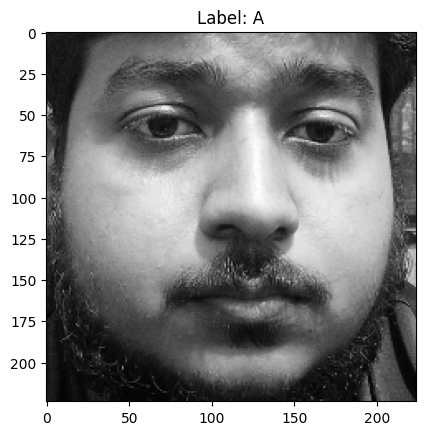

In [13]:
# Plot a sample face
plt.imshow(X_train[0], cmap='gray')
plt.title(f"Label: {label_encoder.inverse_transform([y_train[0]])[0]}")
plt.show()

TRANSFER LEARNING MODEL

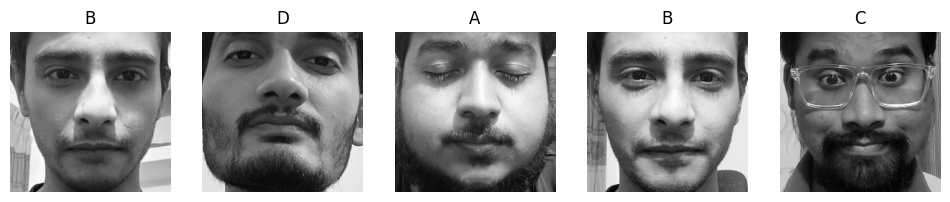

In [14]:
def to_rgb(images_1ch):
    if images_1ch.ndim == 3:
        images_1ch = np.expand_dims(images_1ch, axis=-1)
    images_3ch = np.concatenate([images_1ch, images_1ch, images_1ch], axis=-1)
    return images_3ch

def show_cropped_faces(images, labels_, num=5):
    plt.figure(figsize=(12, 4))
    for i in range(num):
        idx = np.random.randint(0, len(images))
        plt.subplot(1, num, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(label_encoder.inverse_transform([labels_[idx]])[0])
        plt.axis('off')
    plt.show()

show_cropped_faces(X_train, y_train, num=5)

# Convert grayscale images to 3-channel images
X_train_3ch = to_rgb(X_train)
X_val_3ch   = to_rgb(X_val)
X_test_3ch  = to_rgb(X_test)

# Preprocess the images using ResNet50's preprocessing function
X_train_3ch = preprocess_input(X_train_3ch)
X_val_3ch   = preprocess_input(X_val_3ch)
X_test_3ch  = preprocess_input(X_test_3ch)

In [17]:
# Build the Model with Backbone (ResNet50)
from keras.layers import Dense, Flatten, Input, GlobalAveragePooling2D
from keras.models import Model

def create_model(input_shape, num_classes, backbone=ResNet50):
    base_model = backbone(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    # Define the input layer
    inputs = Input(shape=input_shape)

    # Pass the inputs through the backbone
    x = base_model(inputs, training=False)

    # Global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer as a classifier head
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = Model(inputs, outputs)
    return model

In [18]:
# Create the model with input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(np.unique(y_train))
model = create_model(input_shape, num_classes, backbone=ResNet50)

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,376,078 (92.99 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,578 (2.00 MB)

None


In [20]:
# Train the model
history = model.fit(
    X_train_3ch, y_train,
    validation_data=(X_val_3ch, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 859ms/step - accuracy: 0.2236 - loss: 1.5589 - val_accuracy: 0.5750 - val_loss: 1.3356
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.3950 - loss: 1.4108 - val_accuracy: 0.2000 - val_loss: 1.3676
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.2753 - loss: 1.3746 - val_accuracy: 0.2000 - val_loss: 1.3621
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4501 - loss: 1.3256 - val_accuracy: 0.7000 - val_loss: 1.2233
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5933 - loss: 1.2700 - val_accuracy: 0.8750 - val_loss: 1.2027
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7867 - loss: 1.2122 - val_accuracy: 0.9000 - val_loss: 1.1591
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6349 - loss: 1.1790 - val_accuracy: 0.3000 - val_loss: 1.1905
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5627 - loss: 1.1854 - val_accuracy: 0.

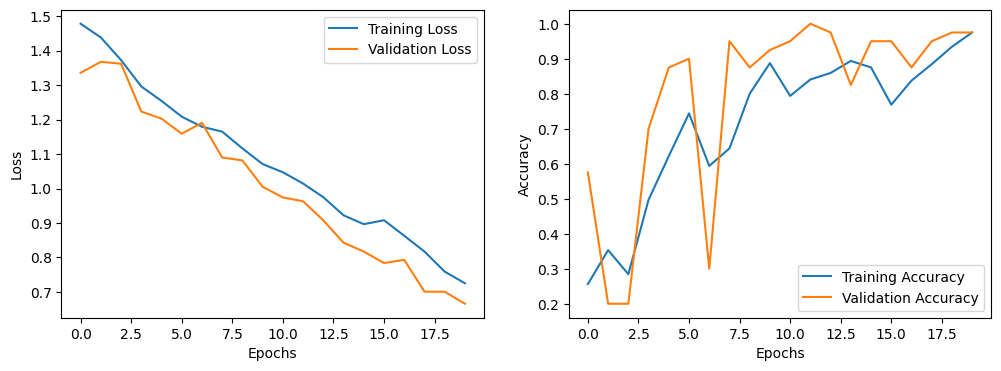

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(X_train_3ch, y_train)
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9698 - loss: 0.6963
Train Loss: 0.7083559632301331, Train Accuracy: 0.9750000238418579


In [29]:
# Evaluate the model on the Validation
val_loss, val_accuracy = model.evaluate(X_val_3ch, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9833 - loss: 0.6581 
Validation Loss: 0.6657926440238953, Validation Accuracy: 0.9750000238418579


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9833 - loss: 0.7088 
Test Loss: 0.7185932993888855, Test Accuracy: 0.9750000238418579
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


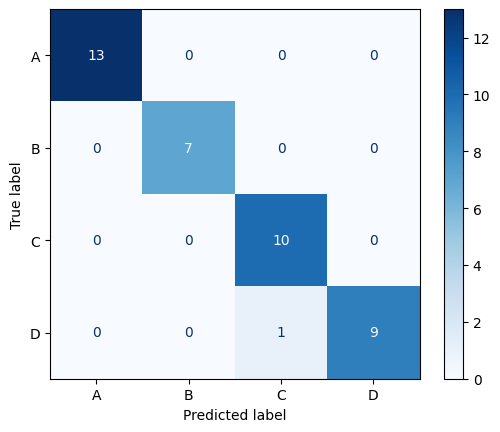

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_3ch, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plot a confusion matrix
y_pred = np.argmax(model.predict(X_test_3ch), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.inverse_transform(np.unique(y_train)))
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


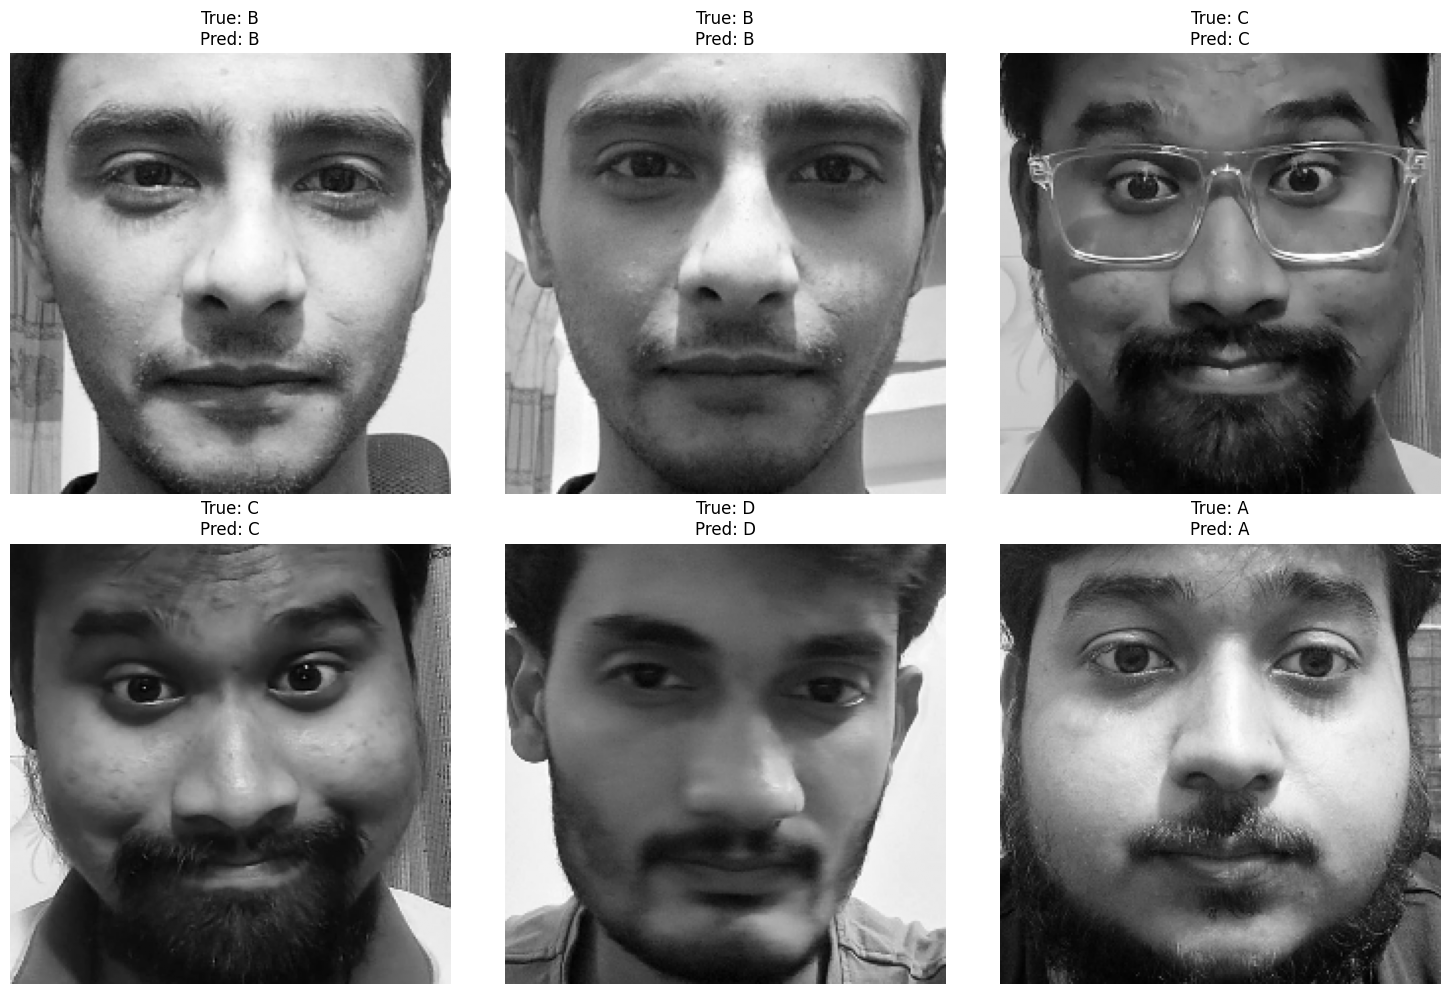

In [23]:
# Display some test images with predictions
import random

num_images = 6
random_indices = np.random.choice(len(X_test), num_images, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    img_input = np.expand_dims(X_test_3ch[idx], axis=0)

    pred_prob = model.predict(img_input)
    pred_class = np.argmax(pred_prob)

    pred_label = label_encoder.inverse_transform([pred_class])[0]
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]

    plt.subplot(2, 3, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()